A good entry point is here in fastai forum: [
Lesson 9 (part 2) preview](https://forums.fast.ai/t/lesson-9-part-2-preview/101336)

This is not yet part 2 but will be a good playground waiting for it.

# Lesson 9

Video at youtube: https://www.youtube.com/watch?v=_7rMfsA24Ls

There is a repo with notebooks at [github diffusion-nbs](https://github.com/fastai/diffusion-nbs)

[Lexica](https://lexica.art/) is a good starting point where you can search for generated images and what were the prompt used.

To experiment stable diffusion, there are multiple options.

I have cloned lessons repo `git clone https://github.com/fastai/diffusion-nbs.git`

And now I am abble to run this notebook `stable_diffusion.ipynb` which is based on diffusers library from huggingface.

## under WSL

I start from this `fastai_hf` environnement

In [1]:
!cat /home/guillaume/_conda_env/fastai_hf.txt

conda remove --name fastai_hf --all
conda create --name fastai_hf --clone fastai
conda activate fastai_hf
pip install -Uq diffusers transformers fastcore
mamba install ipykernel
python -m ipykernel install --user --name=fastai_hf
mamba install matplotlib
mamba install -c conda-forge ipywidgets


#il faut ajouter les certificats Michelin à certifi
#pour cela lancer ~/bin/certifi.sh
#depuis l'environnement fastai_hf
#et verifier que ça marche en lancant python certify_validation.py

which is a clone of `fastai` environement

In [4]:
!cat /home/guillaume/_conda_env/fastai.txt

mamba create -n fastai python=3.9
conda activate fastai
mamba install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia
mamba install -c fastchan fastai nbdev 

For a reason, it fails directly when running `pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")`

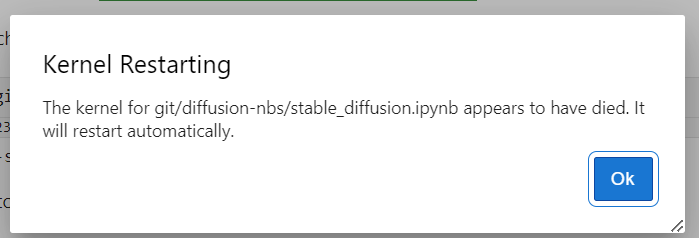

## under linux

As a workaround, I can execute from my full linux box.

But because it has less GPU memory (8 GB), I need to run `pipe.enable_attention_slicing()`  



If your GPU is not big enough to use `pipe`, run `pipe.enable_attention_slicing()`  
As described in the docs:  
> When this option is enabled, the attention module will split the input tensor in slices, to compute attention in several steps. This is useful to save some memory in exchange for a small speed decrease.

In [ ]:
pipe.enable_attention_slicing()

and now it works quite well

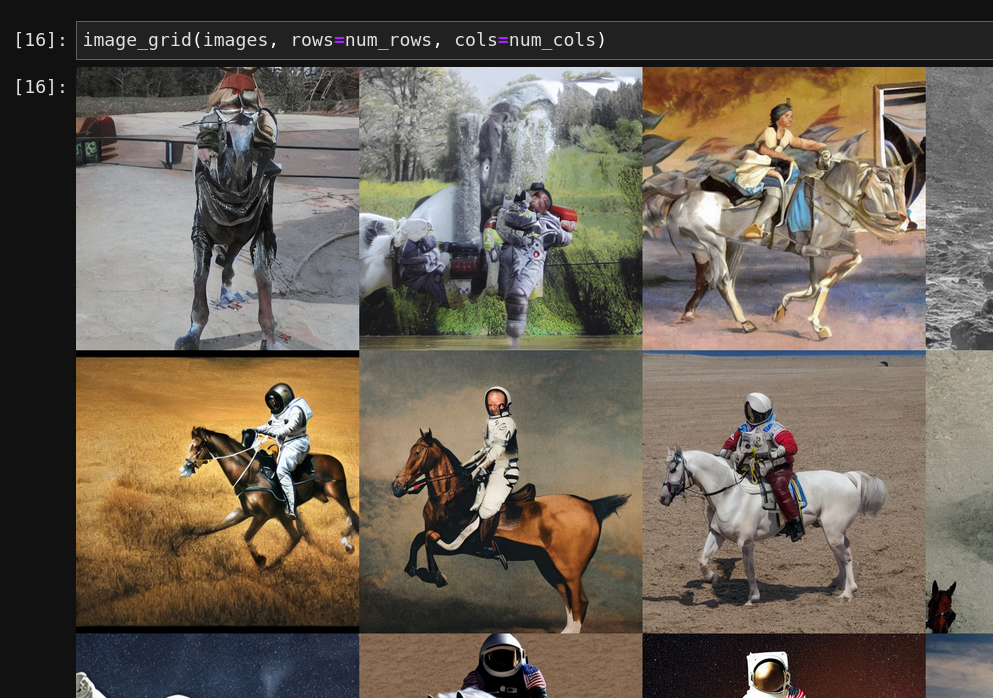

But I don't remember exactly how my fastai environment has been installed. Because I see a reference to fastchan, I guess it was something like `conda install -c fastchan fastai`

In [2]:
!mamba list|grep torch

pytorch                   1.12.1          py3.8_cuda10.2_cudnn7.6.5_0    fastchan
pytorch-mutex             1.0                        cuda    fastchan
torchvision               0.13.1               py38_cu102    fastchan


## different features

### prompt

Direct prompt and prompt with style are quite well known


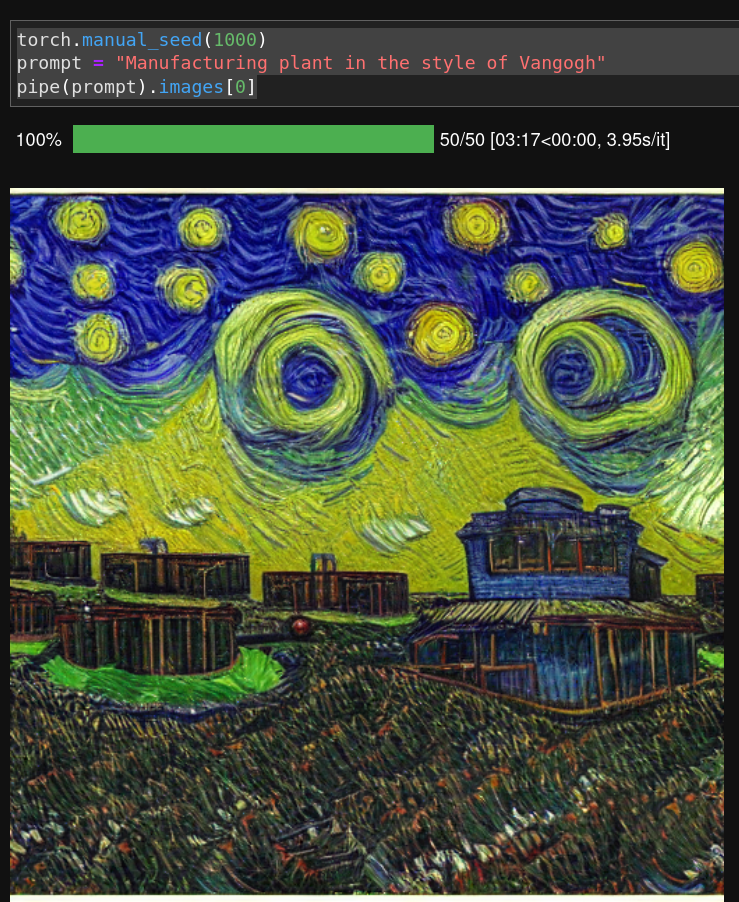

### negative prompt

But I didn't know about negative prompt

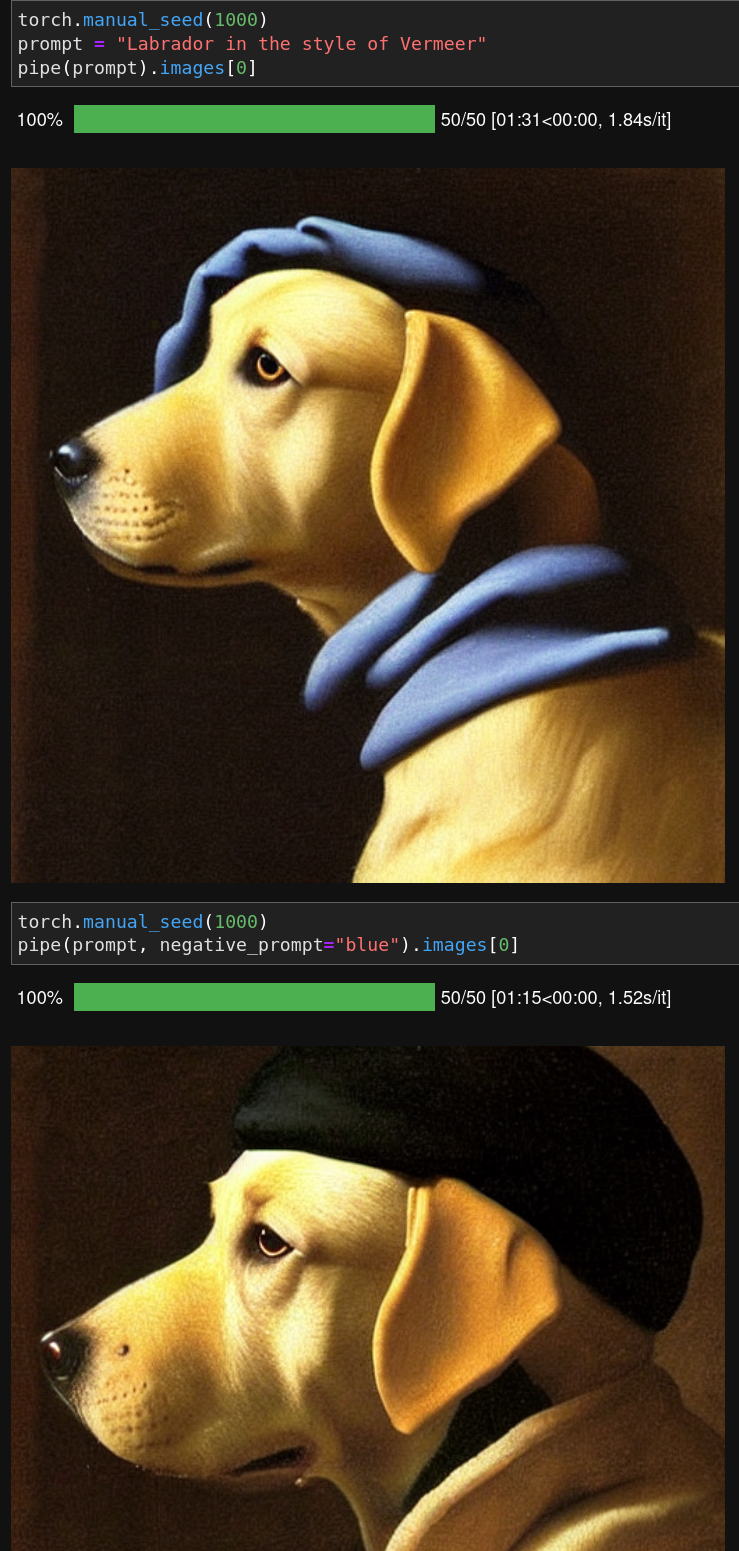

Here all reference to blue have been removded. Quite neat


### sketch - image to image

And with another model image to image, 

you can give an initial image, and this image is then noised and used as a starting point such as in 

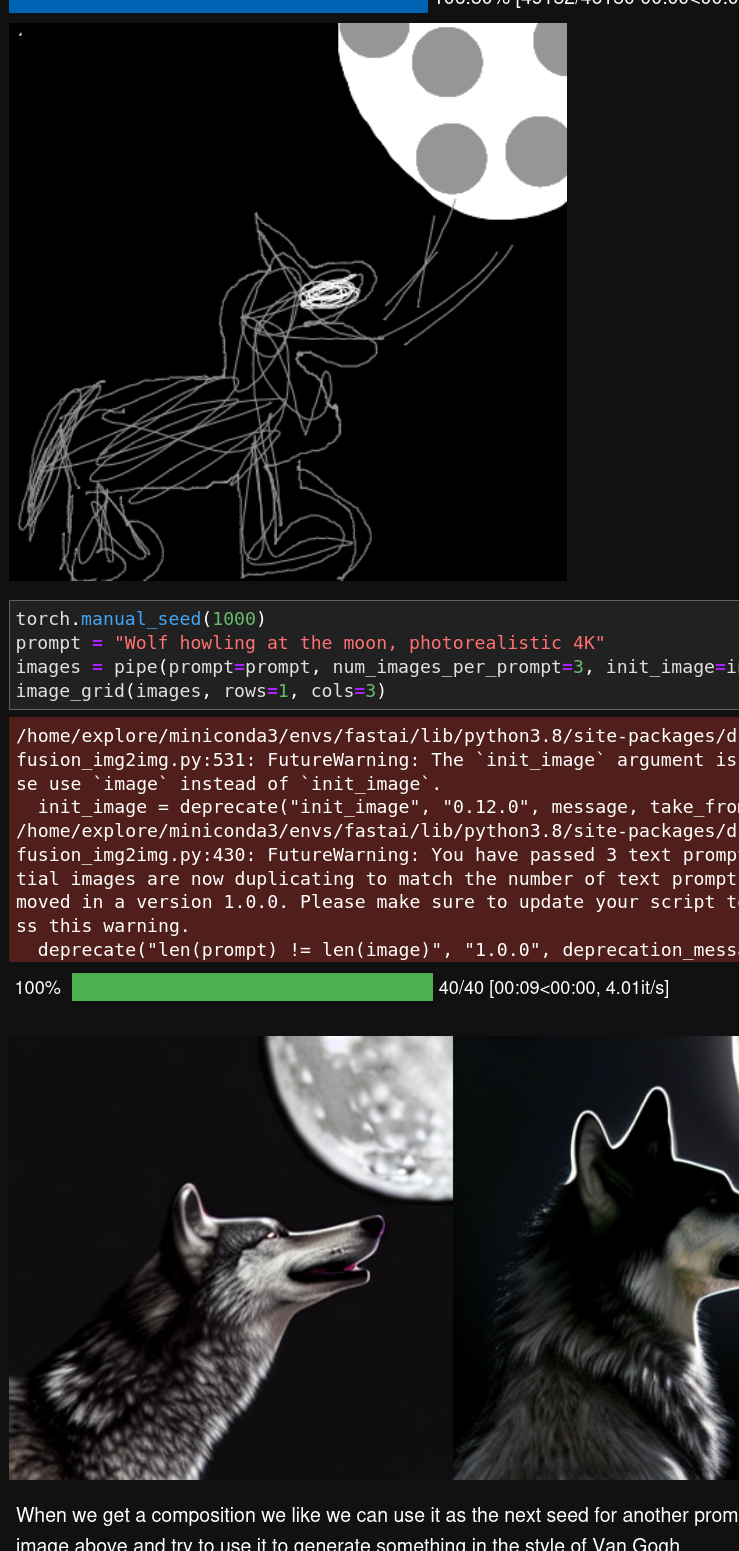

And then we can iterate by picking one of these 3 images and use it as an init image

```python
init_image2 = images[2]
prompt = "Oil painting of wolf howling at the moon by Van Gogh"
images = pipe(prompt=prompt, num_images_per_prompt=3, init_image=init_image2, strength=1, num_inference_steps=70).images
image_grid(images, rows=1, cols=3)
``` 

### add your own tokens

> Textual inversion is a process where you can quickly "teach" a new word to the text model and plain its embeddings close to some visual representation. This is achieved by adding a new token to the vocabulary, freezing the weights of all the models (except the text encoder), and train with a few representative images.
> 
> This is a schematic representation of the process by the [authors of the paper](https://textual-inversion.github.io).

### or retrain existing ones

> For example, we fine-tuned a model with a prompt like `"photo of a sks person"`, using the rare `sks` token to qualify the term `person`, and using photos of Jeremy as the targets. Let's see how it works.

We don't have the detail about how to retrain it though. This is what is used in Dreambooth.

# Lesson 9A - Deep Dive—from @johnowhitaker

Video: https://www.youtube.com/watch?v=0_BBRNYInx8

Notebook: https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb

With my low gpu-memory machine, have to install additional packages
```pip
!pip install accelerate protobuf==3.20
```

Unfortunately I cannot run it:

https://forums.fast.ai/t/lesson-9-part-2-preview/101336/11?u=guillaumeramelet

```log
RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 7.80 GiB total capacity; 6.15 GiB already allocated; 142.06 MiB free; 6.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
```

## the autoencoder

This is quite impressive that vae can compress/decompress with such a factor (/48) and keep this level of quality

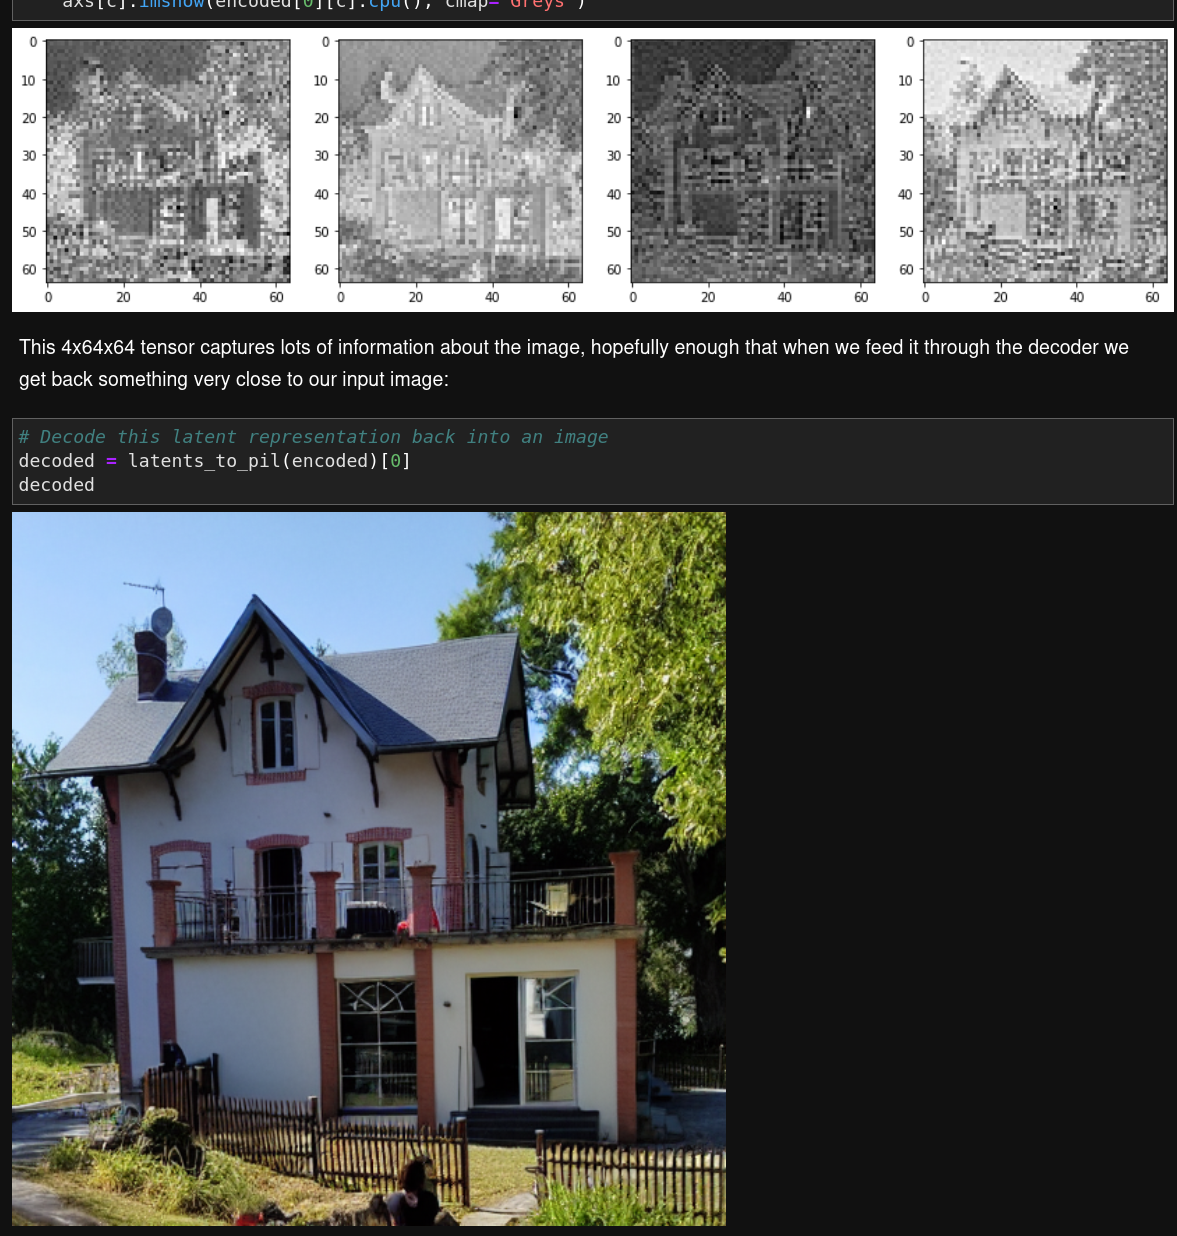

I have to watch this video again to propose a fair understanding of it

# Lesson 9B - the math of diffusion

The video is here: https://www.youtube.com/watch?v=mYpjmM7O-30

by Wasim @seem and Tanishq @ilovescience

They start by explaining notations which is quite helpful.

For example in 
>$q(X^{(0)})$ data distribution

$X$ denotes inputs, $X^{(0)}$ denotes a sequence, one can expect to see $X^{(1)}$, $X^{(2)}$, .., $X^{(n)}$

and $q$ (quite close to $p$) is a probability density function. My representation of this is a curve (given X is of dimension 1) which area under curve equals to 1. And I have questions about how to calculate probability density function for multiple dependent variables. Scikit-learn can help [density estimation](https://scikit-learn.org/stable/modules/density.html) Or VAE? For independant variable, we can just multiply each prob density.

Those notations are from the diffusion paper, published in 2015 by Jascha Sohl-Dickstein, Eric A. Weiss, Niru Maheswaranathan, Surya Ganguli: [Deep Unsupervised Learning using Nonequilibrium Thermodynamics](https://arxiv.org/abs/1503.03585)


$q$ is this kind of magic function as introduced by Jeremy in the 1st video which provides probability that $X^{(0)}$ is **enter your target: mnist or other kind of stuff expected**

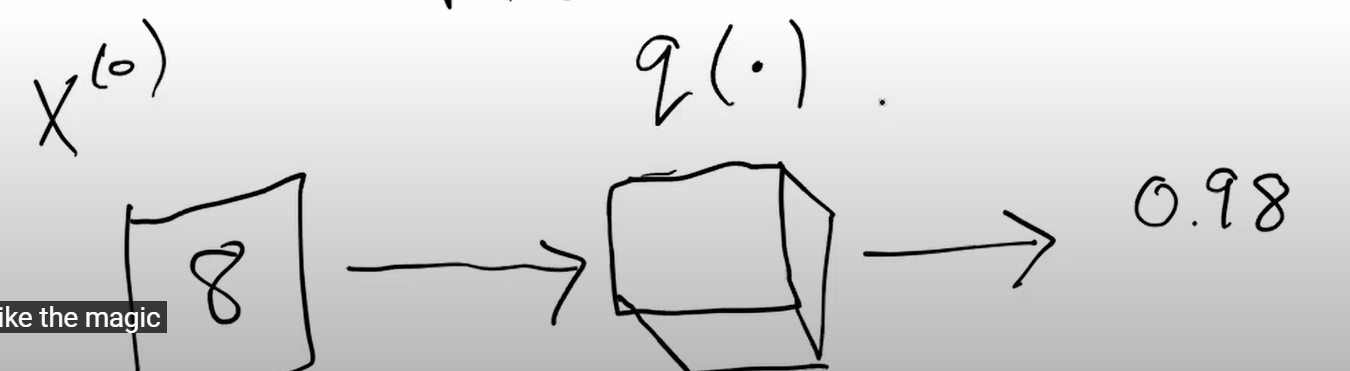

Next notation is $q(X^{(t)}|X^{(t-1)})$

We can think of it as a function $q$ which transforms $X^{(t-1)}$ to $X^{(t)}$ and what is given is again the probability.

We have this formula for it

$q(X^{(t)}|X^{(t-1)}) = \mathcal{N}(X^{(t)}; X^{(t-1)}\sqrt{I-\beta_t}; I\beta_t)$

$X^{(t-1)}\sqrt{I-\beta_t}$ is $\mu$ the mean of this distribution for the normal distribution

$I\beta_t$ is $\Sigma$ the covariance of this distribution for the normal distribution 

When $\beta_t=0$, with $t=1$ we have a mean $\mu=X^{0}$ and a covariance $\Sigma=0$ 

it means in that case noise is null, our function is Identity

When $\beta_t=1$, with $t=1$ we have a mean $\mu=0$ and a covariance $\Sigma=I$ 

in that case we will get pure noise

Someway in between we will have part of the initial image + some noise

## forward diffusion

So the **forward diffusion** will follow this process

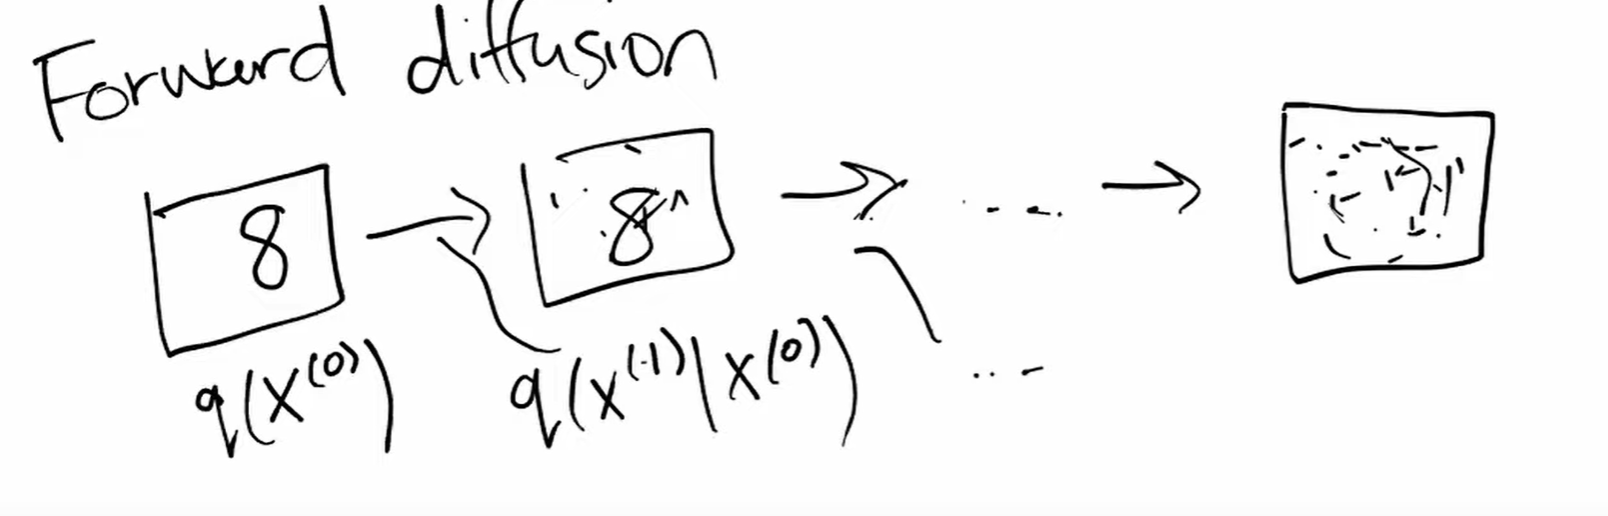

This is a **Markow Process with Gaussians transitions**

by Process we can understand a sequence (t) is involved

by Markov, the things at time t $X^{t}$ depends only on the thing at time t-1 $X^{t-1}$

by transitions it is following the $q$ function $q(X^{(t)}|X^{(t-1)})$

by Gaussian, this function is the normal distribution $\mathcal{N}(X^{(t)}; X^{(t-1)}\sqrt{I-\beta_t}; I\beta_t)$

And by process we mean that we apply baby steps, a high number of times. Maybe 1000 times.

## backward diffusion

We can now think about the backward diffusion process, by going backward with exactly the same logic.

$p(X^{(t-1)}|X^{(t)}) = \mathcal{N}(X^{(t-1)}; \Box ; \Delta )$

where p is the here the conditionnal probability to get clearer and clearer, and $\Box$ is the mean, $\Delta$ is the variance. Those are unknown but can be fit.

We can fit this model by maximizing the likelihood function. Practically we prefer to use log likelihood. (we like its properties to turn products to sums, and by taking exponential such as in normal distribution we get identity which is quite convenient) And more recent works showed that we can use one particular loss to dot it which is **ELBO** (evidence lower bound, evidence is another name for likelihood). elbo being easily calculated, one can use it as a loss function. You can now train a NN to get $\Box$ and $\Delta$.

To match distributions between the forward process and the backward process, we will use special function KL divergence. KL divergence of gaussians can be calculated analytically so it eases the process. 

In 2020, a [paper](https://arxiv.org/abs/2006.11239) introduced a new model **DDPM** (Denoising Diffusion Probabilistic model). Main idea is to simplify diffusion processes by considering only mean. Variance is set as a constant. In that case we can just use mse(noise) as a loss.

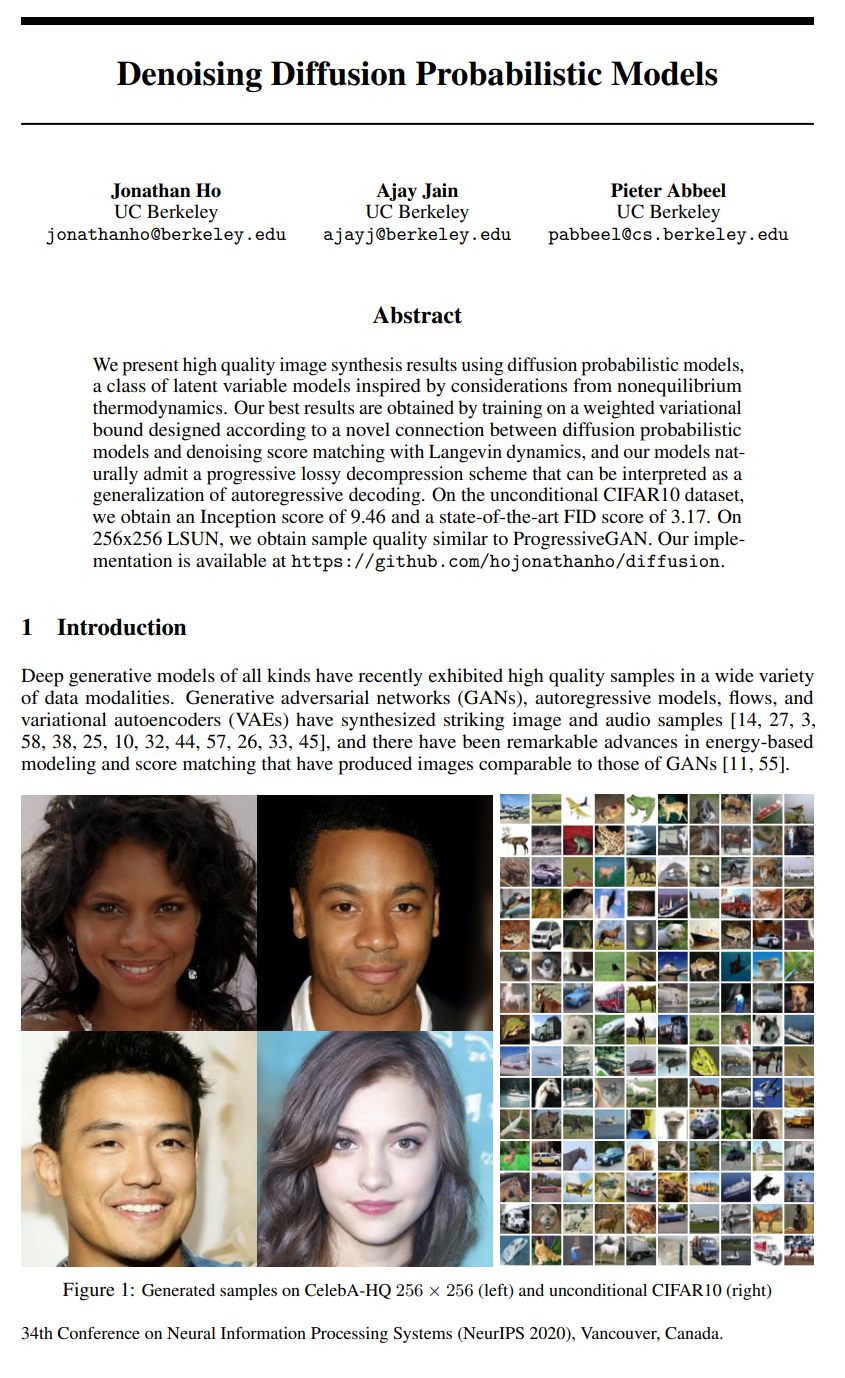